In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_curve, auc

In [84]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

In [85]:
def load_data():
  train_data = pd.read_csv('../pretprocesiranje/train_data.csv')
  test_data = pd.read_csv('../pretprocesiranje/test_data.csv')
  X_train = train_data.iloc[:, :-1].copy()
  y_train = train_data.iloc[:, -1:].copy()
  X_test = test_data.iloc[:, :-1].copy()
  y_test = test_data.iloc[:, -1:].copy()

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

  y_train = y_train.values.ravel()
  y_val = y_val.values.ravel()
  y_test = y_test.values.ravel()

  return X_train, X_val, y_train, y_val, X_test, y_test

def plot_matrix(cm, color):
  class_labels = ['Biology', 'Chemistry', 'Physics']

  plt.figure(figsize=(5, 5))
  plt.imshow(cm, interpolation='nearest', cmap=color)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(class_labels))
  plt.xticks(tick_marks, class_labels)
  plt.yticks(tick_marks, class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

def print_data(real, pred, cm):
  precision = precision_score(real, pred, average='weighted')
  recall = recall_score(real, pred, average='weighted')
  accuracy = accuracy_score(real, pred)
  f1 = f1_score(real, pred, average='weighted')

  accuracy_scores.append(accuracy)
  f1_scores.append(f1)
  precision_scores.append(precision)
  recall_scores.append(recall)

  print("Confusion matrix:")
  print(cm)

  print("-----------------------------------------------------")

  report = classification_report(real, pred, zero_division=0)
  print(report)

In [86]:
def auc_curve_plot(X_train, X_test, y_train, y_test, model):
  classifier_ovr = OneVsRestClassifier(model)
  y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
  y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
  classifier_ovr.fit(X_train, y_train_bin)
  y_scores = classifier_ovr.predict_proba(X_test)

  fpr = {}
  tpr = {}
  roc_auc = {}

  for class_label in range(3):
      fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, class_label], y_scores[:, class_label])
      roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

  plt.figure(figsize=(5, 5))
  colors = ['blue', 'red', 'green']
  classes = ['biologija vs ostale', 'hemija vs ostale', 'fizika vs ostale']
  for class_label, color, class_name in zip(range(3), colors, classes):
      plt.plot(fpr[class_label], tpr[class_label], color=color, lw=2, label=f'{class_name} (AUC = {roc_auc[class_label]:.2f})')

  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('One-vs-Rest AUC Curve')
  plt.legend(loc='lower right')

  plt.show()

In [87]:
def evaluate_model(alpha, color, X_train, X_test, y_train, y_test):
  force_alpha = True

  if alpha != 0.0:
    force_alpha = False

  nb = MultinomialNB(alpha=alpha, force_alpha=force_alpha)
  nb.fit(X_train, y_train)
  y_pred = nb.predict(X_test)

  cm = confusion_matrix(y_test, y_pred)
  plot_matrix(cm, color)
  print_data(y_test, y_pred, cm)

  if color == 'Purples':
    auc_curve_plot(X_train, X_test, y_train, y_test, model=nb)
    return nb


In [88]:
X_train, X_val, y_train, y_val, X_test, y_test = load_data()

#Naive Bayes

ispitujemo ponasanje u zavisnosti od hiperparametra alfa

In [89]:
alphas = [0.0, 0.1, 0.5, 1.0, 2.0]
colors = ['Reds', 'Oranges', 'Oranges', 'Oranges', 'Oranges']

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


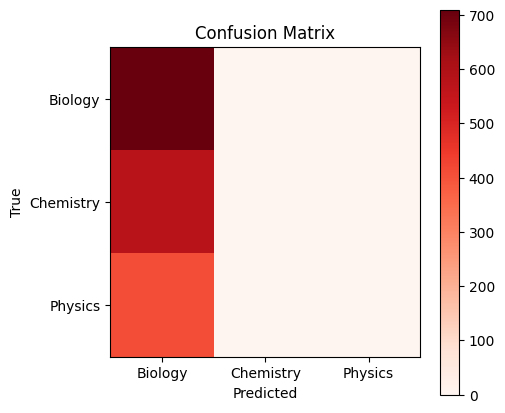

Confusion matrix:
[[710   0   0]
 [578   0   0]
 [410   0   0]]
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       710
           1       0.00      0.00      0.00       578
           2       0.00      0.00      0.00       410

    accuracy                           0.42      1698
   macro avg       0.14      0.33      0.20      1698
weighted avg       0.17      0.42      0.25      1698



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
evaluate_model(alphas[0], colors[0], X_train, X_val, y_train, y_val)

alpha je kao regulizacioni parameter, ako je 0 dolazi do overfittinga i model uopste ne ume da generalizuje, nema smoothing, ne ume da se snadje za kombinacije atribut-klasa koje nije video u treningu

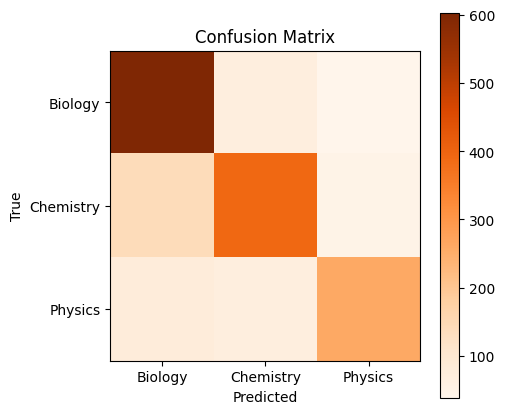

Confusion matrix:
[[602  70  38]
 [140 391  47]
 [ 79  71 260]]
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       710
           1       0.73      0.68      0.70       578
           2       0.75      0.63      0.69       410

    accuracy                           0.74      1698
   macro avg       0.74      0.72      0.73      1698
weighted avg       0.74      0.74      0.73      1698



In [91]:
evaluate_model(alphas[1], colors[1], X_train, X_val, y_train, y_val)

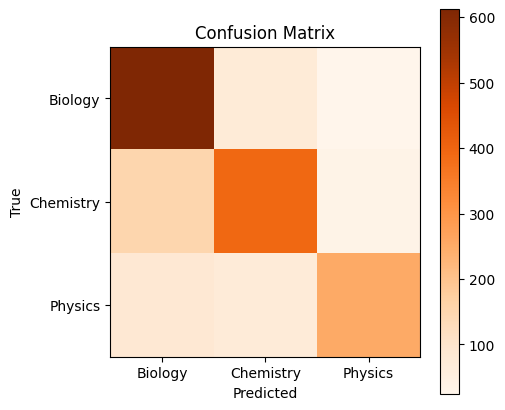

Confusion matrix:
[[612  74  24]
 [151 392  35]
 [ 85  72 253]]
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.86      0.79       710
           1       0.73      0.68      0.70       578
           2       0.81      0.62      0.70       410

    accuracy                           0.74      1698
   macro avg       0.75      0.72      0.73      1698
weighted avg       0.75      0.74      0.74      1698



In [92]:
evaluate_model(alphas[2], colors[2], X_train, X_val, y_train, y_val)

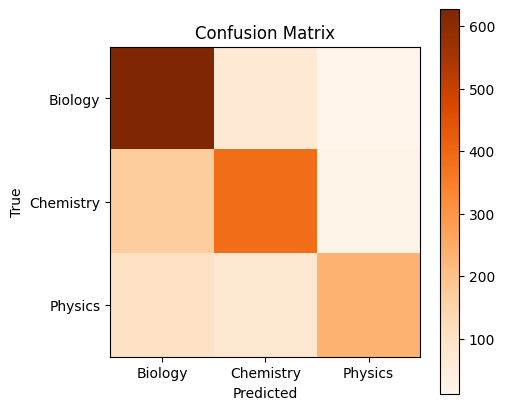

Confusion matrix:
[[627  72  11]
 [171 384  23]
 [101  79 230]]
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       710
           1       0.72      0.66      0.69       578
           2       0.87      0.56      0.68       410

    accuracy                           0.73      1698
   macro avg       0.76      0.70      0.72      1698
weighted avg       0.75      0.73      0.73      1698



In [93]:
evaluate_model(alphas[3], colors[3], X_train, X_val, y_train, y_val)

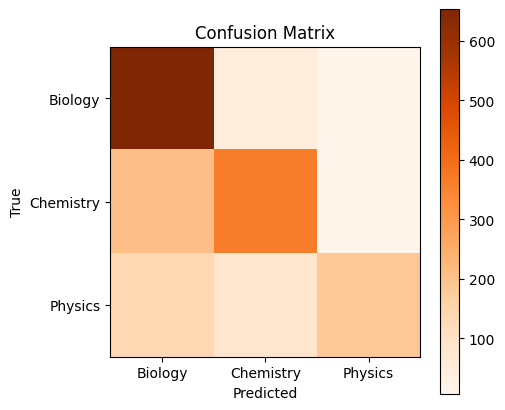

Confusion matrix:
[[653  51   6]
 [206 364   8]
 [139  85 186]]
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       710
           1       0.73      0.63      0.68       578
           2       0.93      0.45      0.61       410

    accuracy                           0.71      1698
   macro avg       0.77      0.67      0.68      1698
weighted avg       0.75      0.71      0.70      1698



In [94]:
evaluate_model(alphas[4], colors[4], X_train, X_val, y_train, y_val)

<Figure size 500x400 with 0 Axes>

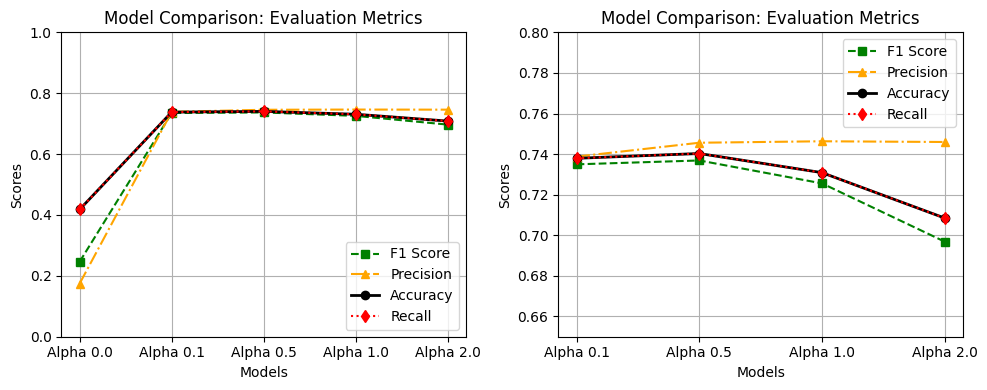

In [95]:
model_names = [f"Alpha {i}" for i in alphas]
good_models = model_names[1:]
plt.figure(figsize=(5, 4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# sve
ax1.plot(model_names, f1_scores, marker='s', linestyle='--', color='green', label='F1 Score')
ax1.plot(model_names, precision_scores, marker='^', linestyle='-.', color='orange', label='Precision')
ax1.plot(model_names, accuracy_scores, marker='o', linestyle='-', linewidth=2, color='black', label='Accuracy')
ax1.plot(model_names, recall_scores, marker='d', linestyle=':', color='red', label='Recall')
ax1.set_ylim(0.0, 1.0)
ax1.set_xlabel('Models')
ax1.set_ylabel('Scores')
ax1.set_title('Model Comparison: Evaluation Metrics')
ax1.legend()
ax1.grid(True)

# uvecano
ax2.plot(model_names[1:], f1_scores[1:], marker='s', linestyle='--', color='green', label='F1 Score')
ax2.plot(model_names[1:], precision_scores[1:], marker='^', linestyle='-.', color='orange', label='Precision')
ax2.plot(model_names[1:], accuracy_scores[1:], marker='o', linestyle='-', linewidth=2, color='black', label='Accuracy')
ax2.plot(model_names[1:], recall_scores[1:], marker='d', linestyle=':', color='red', label='Recall')
ax2.set_ylim(0.65, 0.8)
ax2.set_xlabel('Models')
ax2.set_ylabel('Scores')
ax2.set_title('Model Comparison: Evaluation Metrics')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()

najbolji je alpha=0.5

#Test skup

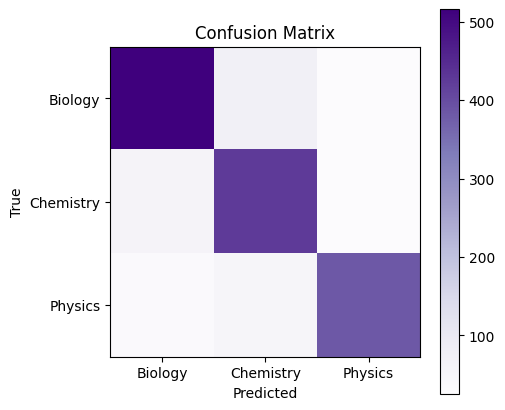

Confusion matrix:
[[516  73  25]
 [ 57 424  25]
 [ 32  51 383]]
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       614
           1       0.77      0.84      0.80       506
           2       0.88      0.82      0.85       466

    accuracy                           0.83      1586
   macro avg       0.84      0.83      0.83      1586
weighted avg       0.84      0.83      0.83      1586



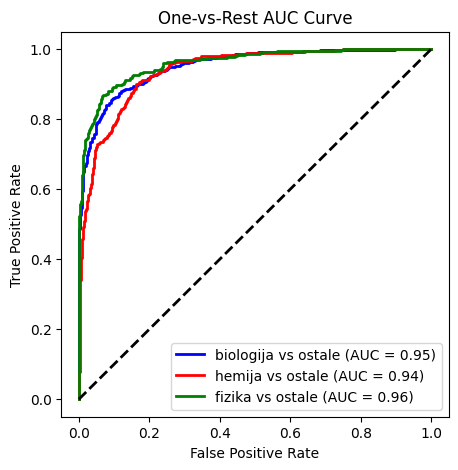

In [96]:
model = evaluate_model(alpha=0.5, color='Purples', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

auc: koliko dobro razaznaje svaku od klasa od ostalih

In [97]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = 5, scoring='accuracy')


In [98]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

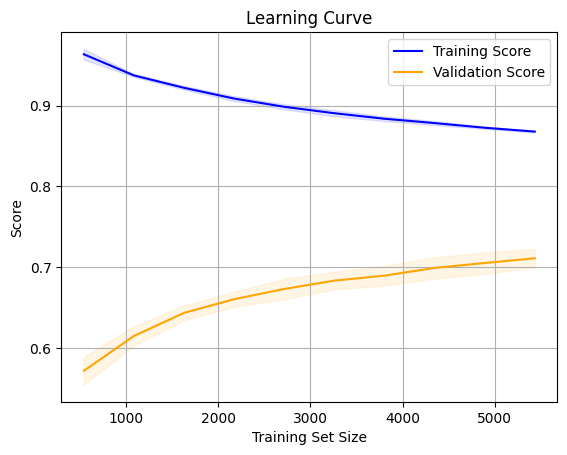

In [99]:
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Score')

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')

plt.legend(loc='best')
plt.grid(True)
plt.show()

In [100]:
joblib.dump(model, 'nb_model.joblib')

['nb_model.joblib']